In [183]:
# Python packages
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import datetime as dt
import numpy as np
from time import sleep

# Local
import configurations as conf
import andorfunctions as andor
#sys.path.append('..')
import CESfunctionsJUNOx23 as cf

# The pyAndorSDK2 is a proprietary package from the ANDOR SDK
from pyAndorSDK2 import atmcd
from pyAndorSDK2 import atmcd_codes as codes
from pyAndorSDK2 import atmcd_errors as errors




In [184]:
#########################################################################################
#####                       PARAMETER CONFIGURATION                                 #####
# These parameters can be changed manually or with a configuration file

### Instrument
temp = -20                                    # Camera temperature
exptime = 0.1#conf.exptime_blank                        # Exposure time in seconds
bckg_shots = conf.bckg_shots                        # Number of background shots
                                                    # (for averaging in analysis)
acqMode = conf.acqMode        
                                                    # Acquisition mode
                                                    # e.g. SINGLE_SCAN, ACCUMULATE
                                                    # check codes for more
accum_number = 50 #conf.accums                          # Number of accumulations (if needed)
accum_cycle = exptime + .01                  # Exp + Delay = Cycle time
                                                    # (only for internal trigger)
readMode = conf.readMode                            # Read mode
trigMode = conf.trigMode                            # Trigger Mode

### Path for saving data
savepath = conf.savepath

#########################################################################################
##### Making a subdirectory for generated files %Y%m%d

directory = dt.datetime.now().strftime('%Y%m%d')
path = os.path.join(savepath,directory)   # path of the folder wherein to store data

# Tries to make a new folder with the current date, does nothing if folder already
# exists

try:
    os.mkdir(path)
except:
    pass

path_file = path + conf.folder_symbol   # full path to append filename when writing



In [185]:
#########################################################################################
#####               INSTRUMENT PREPARATION FOR SAMPLING                             #####
# Starts the instrument object and initializes it
# Stabilizes to the set temperature
# Configures acquisition parameters

sdk = atmcd()  # Load the atmcd library

ret = sdk.Initialize(r"c:\Program Files\Andor SDK\\")   # Initialize camera, path points
                                                        # to DETECTOR.INI
print("Function Initialize returned {}".format(ret))

if errors.Error_Codes.DRV_SUCCESS != ret:
    print("...Could not initialize camera with error {}, will exit".format(ret))
    sys.exit()

# Uncomment the following if you really want to see the serial number
#(ret, iSerialNumber) = sdk.GetCameraSerialNumber()
#print("Function GetCameraSerialNumber returned {} Serial No: {}".format(
#        ret, iSerialNumber))

# Configure the acquisition, lines outsourced to AndorFunctions.py
try:
    andor.prepare_temperature(sdk,temp)
except Exception as e:
    print('Will exit due to following error:',e)
    sys.exit()

Function Initialize returned 20002
Function SetTemperature returned 20002 Set Temperature: -20
Function CoolerON returned 20002
Waiting for temperature to stabilize:
...Current temperature is 23C
...Current temperature is 16C
...Current temperature is 9C
...Current temperature is 1C
...Current temperature is -4C
...Current temperature is -10C
...Current temperature is -16C
...Current temperature is -20C
...Current temperature is -22C
...Current temperature is -19C
...Current temperature is -18C
...Current temperature is -18C
...Current temperature is -19C
...Current temperature is -19C
...Current temperature is -19C
...Current temperature is -19C
...Temperature stabilized


In [7]:
#xpixels = andor.prepare_camera(sdk,acqMode,readMode,trigMode,
#        accum_number,accum_cycle,exptime)

Function SetAcquisitionMode returned 20002
Function SetNumberAccumulations returned 20002
Function SetAccumulationCycleTime returned 20002
Function SetReadMode returned 20002
Function SetTriggerMode returned 20002
Function GetDetector returned 20002 xpixels = 1024 ypixels = 255
Function SetExposureTime returned 20002 time = 0.1s
Function GetAcquisitionTimings returned 20002 exposure = 0.1 accumulate = 10.4994 kinetic = 1049.940063
Function PrepareAcquisition returned 20002


In [186]:
def prepare_camera(sdk,acqMode,readMode,trigMode,accum_number,accum_cycle,exptime):
    ret = sdk.SetAcquisitionMode(acqMode)
    print("Function SetAcquisitionMode returned {}".format(ret))
    print(codes.Acquisition_Mode.ACCUMULATE)
    #### BEGIN Set Number and Cycles for ACCUMULATION MODE
    if acqMode == codes.Acquisition_Mode.ACCUMULATE:
        ret = sdk.SetNumberAccumulations(accum_number)
        print("Function SetNumberAccumulations returned {}".format(ret))
    
        ret = sdk.SetAccumulationCycleTime(accum_cycle)
        print("Function SetAccumulationCycleTime returned {}".format(ret))
    #### END Set Number and Cycles for ACCUMULATION MODE

    ret = sdk.SetReadMode(readMode)
    print("Function SetReadMode returned {}".format(ret))

    ret = sdk.SetTriggerMode(trigMode)
    print("Function SetTriggerMode returned {}".format(ret))

    (ret, xpixels, ypixels) = sdk.GetDetector()
    print("Function GetDetector returned {} xpixels = {} ypixels = {}".format(
        ret, xpixels, ypixels))

    ret = sdk.SetExposureTime(exptime)
    print("Function SetExposureTime returned {} time = {}s".format(ret,exptime))

    (ret, fminExposure, fAccumulate, fKinetic) = sdk.GetAcquisitionTimings()
    print("Function GetAcquisitionTimings returned",
            "{} exposure = {} accumulate = {} kinetic = {}".format(ret, fminExposure, 
                                                             fAccumulate, fKinetic))

    ret = sdk.PrepareAcquisition()
    print("Function PrepareAcquisition returned {}".format(ret))
    return xpixels,fKinetic


In [242]:
accum_number,accum_cycle,exptime =(1,.105,.1)
xpixels,runtime = prepare_camera(sdk,acqMode,readMode,trigMode,
        accum_number,accum_cycle,exptime)

Function SetAcquisitionMode returned 20002
2
Function SetNumberAccumulations returned 20002
Function SetAccumulationCycleTime returned 20002
Function SetReadMode returned 20002
Function SetTriggerMode returned 20002
Function GetDetector returned 20002 xpixels = 1024 ypixels = 255
Function SetExposureTime returned 20002 time = 0.1s
Function GetAcquisitionTimings returned 20002 exposure = 0.1 accumulate = 0.10369 kinetic = 0.10369
Function PrepareAcquisition returned 20002


Acquisition
Function StartAcquisition returned 20002
Function GetNumberNewImages returned 20002 first= 1 last = 1
Function GetImages16 returned 20002 first pixel = 300 size = 1024
(1024,)
0.13577


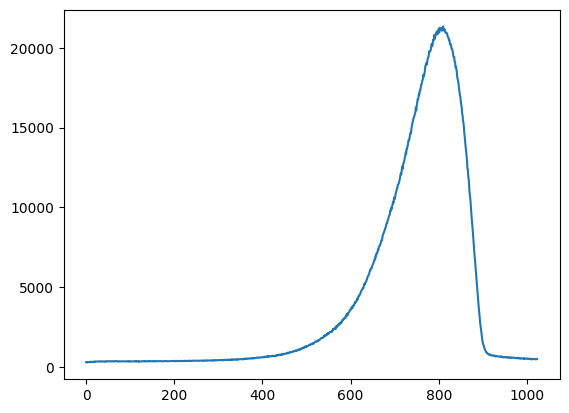

In [243]:
print("Acquisition")
tt1=dt.datetime.now() # for testing wait delay     
ret = sdk.StartAcquisition()
print("Function StartAcquisition returned {}".format(ret))
    
    #
#ret,status = sdk.GetStatus()
#while status != 20073:
    
#    sleep(runtime/20)
#    ret,status = sdk.GetStatus()
    #print(status)
ret = sdk.WaitForAcquisition()
#print("Function WaitForAcquisition returned {}".format(ret))
    
    #
    #
(ret, first, last) = sdk.GetNumberNewImages()
print("Function GetNumberNewImages returned {} first= {} last = {}".format(ret, first, last))

(ret, arr, validfirst, validlast) = sdk.GetImages16(1, 1, xpixels)
print("Function GetImages16 returned {} first pixel = {} size = {}".format(ret, arr[0], xpixels))
print(arr.shape)
tt2=dt.datetime.now() # for testing wait delay
print((tt2-tt1).total_seconds())
plt.plot(arr)


(1024,)
15.297598


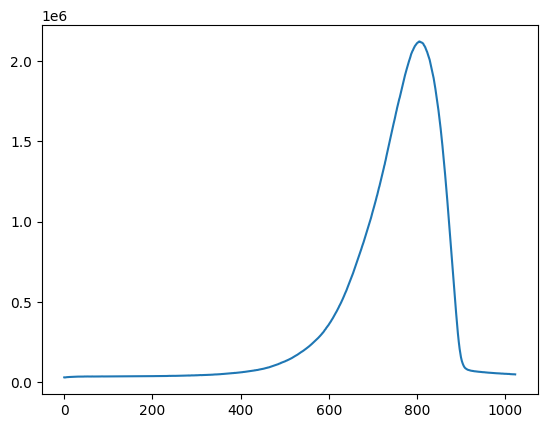

In [244]:
tt1=dt.datetime.now() # for testing wait delay  
counts = np.zeros(xpixels)
for i in range(100):
    #print("Acquisition ",i)
   
    ret = sdk.StartAcquisition()
    #print("Function StartAcquisition returned {}".format(ret))
    
    #
    #ret,status = sdk.GetStatus()
    #while status != 20073:
    #    sleep(.1)
    #    ret,status = sdk.GetStatus()
    #print(status)
    ret = sdk.WaitForAcquisition()
    #print("Function WaitForAcquisition returned {}".format(ret))
    
    #
    #
    (ret, arr, validfirst, validlast) = sdk.GetImages16(1, 1, xpixels)
    #print("Function GetImages16 returned {} first pixel = {} size = {}".format(ret, arr[0], xpixels))
    counts = counts+arr

print(counts.shape)
tt2=dt.datetime.now() # for testing wait delay
print((tt2-tt1).total_seconds())
plt.plot(counts)



Function GetImages16 returned 20002 first pixel = 14858 size = 1024
(1024,)


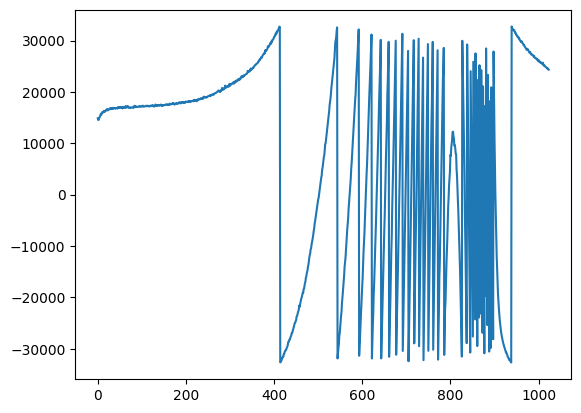

In [225]:

(ret, arr, validfirst, validlast) = sdk.GetImages16(1, 1, xpixels)
print("Function GetImages16 returned {} first pixel = {} size = {}".format(ret, arr[0], xpixels))
print(arr.shape)
plt.plot(arr)


In [226]:
sdk.GetStatus()

(20002, 20073)

In [46]:
sdk.AbortAcquisition()

20002

In [23]:
ret,capas=sdk.GetCapabilities()

In [25]:
capas

In [190]:
from pyAndorSpectrograph.spectrograph import ATSpectrograph

#Load libraries
spc = ATSpectrograph()

#Initialize libraries
shm = spc.Initialize("")
print("Function Initialize returned {}".format(
    spc.GetFunctionReturnDescription(shm, 64)[1]))


Function Initialize returned SUCCESS


In [191]:
(shm, serial) = spc.GetSerialNumber(0, 64)
print("Function GetSerialNumber returned : {} Serial No: {}".format(
            spc.GetFunctionReturnDescription(shm, 64)[1], serial))

(shm, present) = spc.IsAccessoryPresent(0)
print("Function IsAccessoryPresent returned: {} present: {}".format(
            spc.GetFunctionReturnDescription(shm, 64)[1], present))

(shm, present) = spc.IsSlitPresent(0, 1)
print("Function IsSlitPresent returned: {} present: {}".format(
            spc.GetFunctionReturnDescription(shm, 64)[1], present))

(shm, present) = spc.IsFilterPresent(0)
print("Function IsFilterPresent returned: {} present: {}".format(
            spc.GetFunctionReturnDescription(shm, 64)[1], present))

(shm, present) = spc.IsFlipperMirrorPresent(0, 1)
print("Function IsFlipperMirrorPresent returned: {} present: {}".format(
            spc.GetFunctionReturnDescription(shm, 64)[1], present))

(shm, present) = spc.IsFocusMirrorPresent(0)
print("Function IsFocusMirrorPresent returned: {} present: {}".format(
            spc.GetFunctionReturnDescription(shm, 64)[1], present))

(shm, present) = spc.IsGratingPresent(0)
print("Function GratingIsPresent returned: {} present: {}".format(
            spc.GetFunctionReturnDescription(shm, 64)[1], present))

(shm, present) = spc.IsIrisPresent(0, 1)
print("Function IsIrisPresent returned: {} present: {}".format(
            spc.GetFunctionReturnDescription(shm, 64)[1], present))

#(shm, info) = spc.GetFilterInfo(0, 1, 64)
#print("Function GetFilterInfo returned: {} Info: {}".format(
#            spc.GetFunctionReturnDescription(shm, 64)[1], info))

(shm, info) = spc.IsShutterModePossible(0, 1)
print("Function IsShutterModePossible returned: {} Info: {}".format(
            spc.GetFunctionReturnDescription(shm, 64)[1], info))

(shm, present) = spc.IsShutterPresent(0)
print("Function IsShutterPresent returned: {} present: {}".format(
            spc.GetFunctionReturnDescription(shm, 64)[1], present))

(shm, present) = spc.IsSlitPresent(0, 3)
print("Function IsSlitPresent returned: {} present: {}".format(
            spc.GetFunctionReturnDescription(shm, 64)[1], present))

(shm, present) = spc.IsWavelengthPresent(0)
print("Function IsWavelengthPresent returned: {} present: {}".format(
            spc.GetFunctionReturnDescription(shm, 64)[1], present))

(shm, pos) = spc.GetFlipperMirrorMaxPosition(0, 1)
print("Function GetFlipperMirrorMaxPosition returned: {} Pos: {}".format(
            spc.GetFunctionReturnDescription(shm, 64)[1], pos))


Function GetSerialNumber returned : SUCCESS Serial No: SR1871
Function IsAccessoryPresent returned: SUCCESS present: 0
Function IsSlitPresent returned: SUCCESS present: 1
Function IsFilterPresent returned: SUCCESS present: 0
Function IsFlipperMirrorPresent returned: SUCCESS present: 0
Function IsFocusMirrorPresent returned: SUCCESS present: 0
Function GratingIsPresent returned: SUCCESS present: 1
Function IsIrisPresent returned: SUCCESS present: 0
Function IsShutterModePossible returned: SUCCESS Info: 1
Function IsShutterPresent returned: SUCCESS present: 1
Function IsSlitPresent returned: SUCCESS present: 0
Function IsWavelengthPresent returned: SUCCESS present: 1
Function GetFlipperMirrorMaxPosition returned: SUCCESS Pos: 0


In [192]:
(shm, present) = spc.IsSlitPresent(0, 1)
print("Function IsSlitPresent returned: {} present: {}".format(
            spc.GetFunctionReturnDescription(shm, 64)[1], present))
(shm, present) = spc.IsSlitPresent(0, 2)
print("Function IsSlitPresent returned: {} present: {}".format(
            spc.GetFunctionReturnDescription(shm, 64)[1], present))
(shm, present) = spc.IsSlitPresent(0, 3)
print("Function IsSlitPresent returned: {} present: {}".format(
            spc.GetFunctionReturnDescription(shm, 64)[1], present))
(shm, present) = spc.IsSlitPresent(0, 4)
print("Function IsSlitPresent returned: {} present: {}".format(
            spc.GetFunctionReturnDescription(shm, 64)[1], present))

(shm, width) = spc.GetSlitWidth(0, 1)
print("Function GetSlitWidth returned: {} width: {}".format(
    spc.GetFunctionReturnDescription(shm, 64)[1], width))

Function IsSlitPresent returned: SUCCESS present: 1
Function IsSlitPresent returned: SUCCESS present: 0
Function IsSlitPresent returned: SUCCESS present: 0
Function IsSlitPresent returned: SUCCESS present: 0
Function GetSlitWidth returned: SUCCESS width: 100.0


In [194]:
(shm, present) = spc.IsShutterPresent(0)
print("Function IsShutterPresent returned: {} present: {}".format(
            spc.GetFunctionReturnDescription(shm, 64)[1], present))

shm = spc.SetShutter(0,1)
print("Function SetShutter returned: {}".format(
            spc.GetFunctionReturnDescription(shm, 64)[1],))

(shm, shutter) = spc.GetShutter(0)
print("Function GetShutter returned: {} shutter: {}".format(
            spc.GetFunctionReturnDescription(shm, 64)[1], shutter))

Function IsShutterPresent returned: SUCCESS present: 1
Function SetShutter returned: SUCCESS
Function GetShutter returned: SUCCESS shutter: 1


In [107]:
(shm, grat) = spc.GetGrating(0)
print("Function GetGrating returned: {} grating: {}".format(
            spc.GetFunctionReturnDescription(shm, 64)[1], grat))

#(shm, ginfo) = spc.GetGratingInfo(0)
#print("Function IsWavelengthPresent returned: {} present: {}".format(
#            spc.GetFunctionReturnDescription(shm, 64)[1], ginfo))

Function GetGrating returned: SUCCESS grating: 3


In [108]:
(shm, wavelength) = spc.GetWavelength(0)
print("Function GetWavelength returned: {} wavelength: {}".format(
            spc.GetFunctionReturnDescription(shm, 64)[1], wavelength))

(shm, minw,maxw) = spc.GetWavelengthLimits(0,3)
print("Function GetWavelengthLimits returned: {} min: {} max: {}".format(
            spc.GetFunctionReturnDescription(shm, 64)[1], minw,maxw))

Function GetWavelength returned: SUCCESS wavelength: 375.0049743652344
Function GetWavelengthLimits returned: SUCCESS min: 0.0 max: 935.0


In [245]:
andor.shutdown_camera(sdk)


Function GetStatus returned 20002 with status 20073
Function CoolerOFF returned 20002
Waiting for temperature to reach 0 C
Function ShutDown returned 20002


In [246]:
shm = spc.Close()
print("Function Close returned {}".format(
        spc.GetFunctionReturnDescription(shm, 64)[1]))


Function Close returned SUCCESS
